In [1]:
from dask.distributed import Client
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import glob
import numpy as np
import rioxarray

import geopandas as gpd 
import fiona 
import pandas as pd 
import datetime as dt
import tqdm

from rasterio import features
from affine import Affine

from sea_breeze import utils
from sea_breeze.sea_breeze_funcs import rotate_wind

def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    scale = Affine.scale(lon[1] - lon[0], lat[1] - lat[0])
    return trans * scale

def rasterize(shapes, coords, fill=np.nan, **kwargs):
    """Rasterize a list of (geometry, fill_value) tuples onto the given
    xray coordinates. This only works for 1d latitude and longitude
    arrays.
    """
    transform = transform_from_latlon(coords['lat'], coords['lon'])
    out_shape = (len(coords['lat']), len(coords['lon']))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    return xr.DataArray(raster, coords=coords, dims=('lat', 'lon'))

def load_nemosis(path,region=None):

    df = pd.read_csv(path,skiprows=[0])
    df["SETTLEMENTDATE"] = pd.to_datetime(df["SETTLEMENTDATE"])
    df = df[["SETTLEMENTDATE","REGIONID","TOTALDEMAND"]].dropna()
    df = df.drop_duplicates(["SETTLEMENTDATE","REGIONID"])
    
    if region is None:
        df = df.groupby("SETTLEMENTDATE").sum()
        df = df.loc[df.index.minute == 0]
        return df[["TOTALDEMAND"]]
    else:
        df = df[df["REGIONID"]==region]
        df = df.set_index("SETTLEMENTDATE").sort_index()
        df = df.loc[df.index.minute == 0]
        return df

## Read in offshore wind shapefiles, from AEMO REZ file and Geoscience Australia/DCCEEW

In [2]:
f=gpd.read_file("/g/data/ng72/ab4502/coastline_data/Indicative_REZ_boundaries_2024_GIS_data.kml")
rez_states = np.array([n[0] for n in f["Name"]])
offshore_inds = [18,19,27,28,38,42]
f = f.loc[offshore_inds]

f2=gpd.read_file("/g/data/ng72/ab4502/coastline_data/OffshoreRenewable_Energy_Infrastructure_Regions_-7052837244166384748.kmz").iloc[[10]]
f = pd.concat([f,f2])

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/g/data/xp65/public/apps/med_conda/envs/ana

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38735,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:40435,Total threads: 2
Dashboard: /proxy/43391/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:44755,


## Load BARRA-C2 hourly composited wind data (capacity factor)

In [4]:
#Load hourly composited wind data

uname = "ua100m"
vname = "va100m"

files = np.sort(glob.glob("/scratch/ng72/ab4502/hourly_composites/barra_c/barra_c_hourly_"+uname+"_"+vname+"*.nc"))
file_dates = [pd.to_datetime(f.split("/")[-1].split("_")[-2]) for f in files]
file_years = np.array([d.year for d in file_dates])
file_months = np.array([d.month for d in file_dates])

ds_warm = xr.open_mfdataset(
    files[np.in1d(file_months,[11,12,1,2,3,4])],
    concat_dim=xr.DataArray(np.array(file_dates)[np.in1d(file_months,[11,12,1,2,3,4])],dims="month"),
    combine="nested"
)
ds_cool = xr.open_mfdataset(
    files[np.in1d(file_months,[5,6,7,8,9,10])],
    concat_dim=xr.DataArray(np.array(file_dates)[np.in1d(file_months,[5,6,7,8,9,10])],dims="month"),
    combine="nested"
)
ds = xr.concat([ds_warm, ds_cool],dim="month")

In [5]:
#Load extra barra-c info

angle_ds = xr.open_dataset("/g/data/ng72/ab4502/coastline_data/barra_c.nc").sel(lon=ds.lon,lat=ds.lat)
orog = xr.open_dataset("/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/fx/orog/latest/orog_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1.nc")
lsm = xr.open_dataset("/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/fx/sftlf/latest/sftlf_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1.nc").sel(lon=ds.lon,lat=ds.lat)

In [6]:
#Match rez shapefile to barra-c grid

shapes = [(shape, n) for n, shape in enumerate(f.geometry)]
raster = rasterize(shapes,{"lat":ds.lat,"lon":ds.lon},fill=np.nan)

xx,yy=np.meshgrid(raster.lon,raster.lat)
#Split the Vic Gippsland offshore REZ into two
raster = xr.where(((raster==2) & (xx<147.2) & (yy<-39)), raster.max()+1, raster)

## Define coastlines of interest adjacent to offshore wind zones and plot

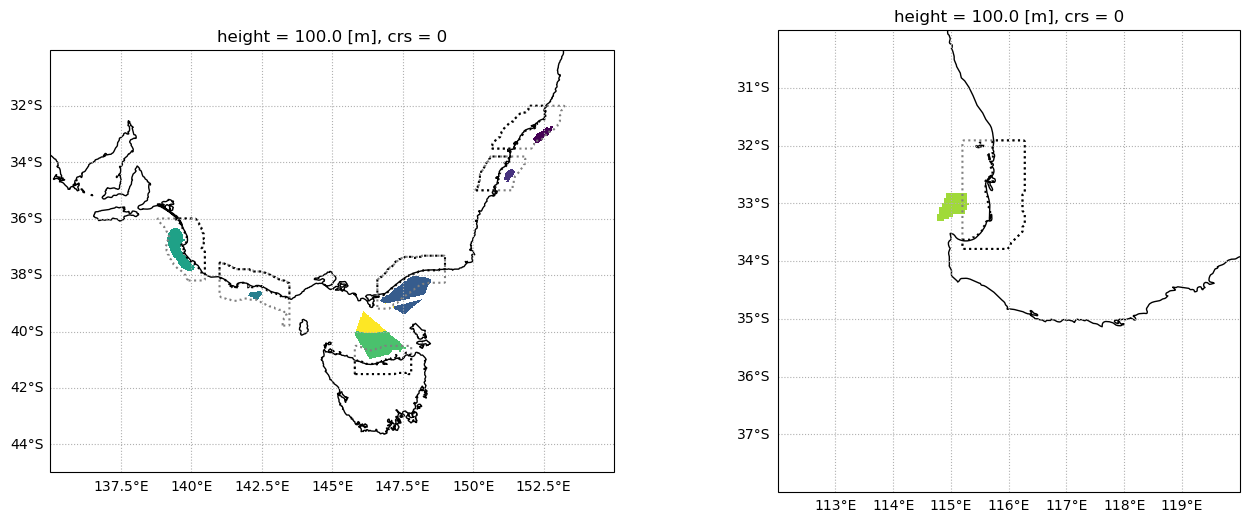

In [7]:
def define_coastal_region(sb_lat_slice,sb_lon_slice,angle_ds,lsm):
    land = xr.where(
        (angle_ds.lat<sb_lat_slice.stop) &
            (angle_ds.lat>sb_lat_slice.start) & 
            (angle_ds.lon>sb_lon_slice.start) & 
            (angle_ds.lon<sb_lon_slice.stop) & 
            (angle_ds.min_coast_dist <= 50) &
            (lsm), 1, 0 )
    land_sea = xr.where(
        (angle_ds.lat<sb_lat_slice.stop) &
            (angle_ds.lat>sb_lat_slice.start) & 
            (angle_ds.lon>sb_lon_slice.start) & 
            (angle_ds.lon<sb_lon_slice.stop) & 
            (angle_ds.min_coast_dist <= 50), 1, 0 )
    return land,land_sea

plt.figure(figsize=[16,6])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
raster.plot(add_colorbar=False)
plt.xlim([135,155])
plt.ylim([-45,-30])
ax.coastlines()

gipps_lon_slice = slice(146.6,149)
gipps_lat_slice = slice(-39.2,-36.5)
gipps_shape,gipps_shape_landsea = define_coastal_region(gipps_lat_slice,gipps_lon_slice,angle_ds,lsm.sftlf>=0.5)

illawara_lat_slice = slice(-35,-33.8)
illawara_lon_slice = slice(149,154)
illawara_shape,illawara_shape_landsea = define_coastal_region(illawara_lat_slice,illawara_lon_slice,angle_ds,lsm.sftlf>=0.5)

newcastle_lat_slice = slice(-33.5,-32)
newcastle_lon_slice = slice(149,154)
newcastle_shape,newcastle_shape_landsea = define_coastal_region(newcastle_lat_slice,newcastle_lon_slice,angle_ds,lsm.sftlf>=0.5)

southern_lat_slice = slice(-39.8,-37)
southern_lon_slice = slice(141,143.5)
southern_shape,southern_shape_landsea = define_coastal_region(southern_lat_slice,southern_lon_slice,angle_ds,lsm.sftlf>=0.5)

tas_lat_slice = slice(-41.5,-40.5)
tas_lon_slice = slice(145.8,147.8)
tas_shape,tas_shape_landsea = define_coastal_region(tas_lat_slice,tas_lon_slice,angle_ds,lsm.sftlf>=0.5)

sa_lat_slice = slice(-38.2,-36)
sa_lon_slice = slice(138.8,140.5)
sa_shape,sa_shape_landsea = define_coastal_region(sa_lat_slice,sa_lon_slice,angle_ds,lsm.sftlf>=0.5)

for shape,shape_landsea in zip(
    [gipps_shape,illawara_shape,newcastle_shape,tas_shape,southern_shape,sa_shape],
    [gipps_shape_landsea,illawara_shape_landsea,newcastle_shape_landsea,tas_shape_landsea,southern_shape_landsea,sa_shape_landsea]):
    
    xr.plot.contour(shape_landsea,levels=1,colors=["grey"],linestyles=":")
    xr.plot.contour(shape,levels=1,colors=["k"],linestyles=":")

ax.gridlines(ls=":",draw_labels=["bottom","left"])



ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
raster.plot(add_colorbar=False)
plt.xlim([112,120])
plt.ylim([-38,-30])
ax.coastlines()

bunbury_lat_slice = slice(-33.8,-31.9)
bunbury_lon_slice = slice(115.2,116.3)
bunbury_shape,bunbury_shape_landsea = define_coastal_region(bunbury_lat_slice,bunbury_lon_slice,angle_ds,lsm.sftlf>=0.5)

xr.plot.contour(bunbury_shape_landsea,levels=1,colors=["grey"],linestyles=":")
xr.plot.contour(bunbury_shape,levels=1,colors=["k"],linestyles=":")

ax.gridlines(ls=":",draw_labels=["bottom","left"])

## Plot the max diurnal timing of CF against SB objects

In [8]:
lon_slice = slice(112,155)
lat_slice = slice(-45,-30)
ds_mean_djf = ds.cf.sel(month=np.in1d(ds.month.dt.month,[1,2,12]),lat=lat_slice,lon=lon_slice).mean("month").persist()
sb_obj_aest = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",engine="zarr",chunks={}).mask.sel(lat=lat_slice,lon=lon_slice).persist()
sb_obj_awst = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_awst_19790101_20250101.zarr",engine="zarr",chunks={}).mask.sel(lat=lat_slice,lon=lon_slice).persist()
sb_aest_mean_djf = sb_obj_aest.sel(time=np.in1d(sb_obj_aest.time.dt.month,[1,2,12])).mean("time").persist()
sb_awst_mean_djf = sb_obj_awst.sel(time=np.in1d(sb_obj_awst.time.dt.month,[1,2,12])).mean("time").persist()

(-38.0, -30.0)

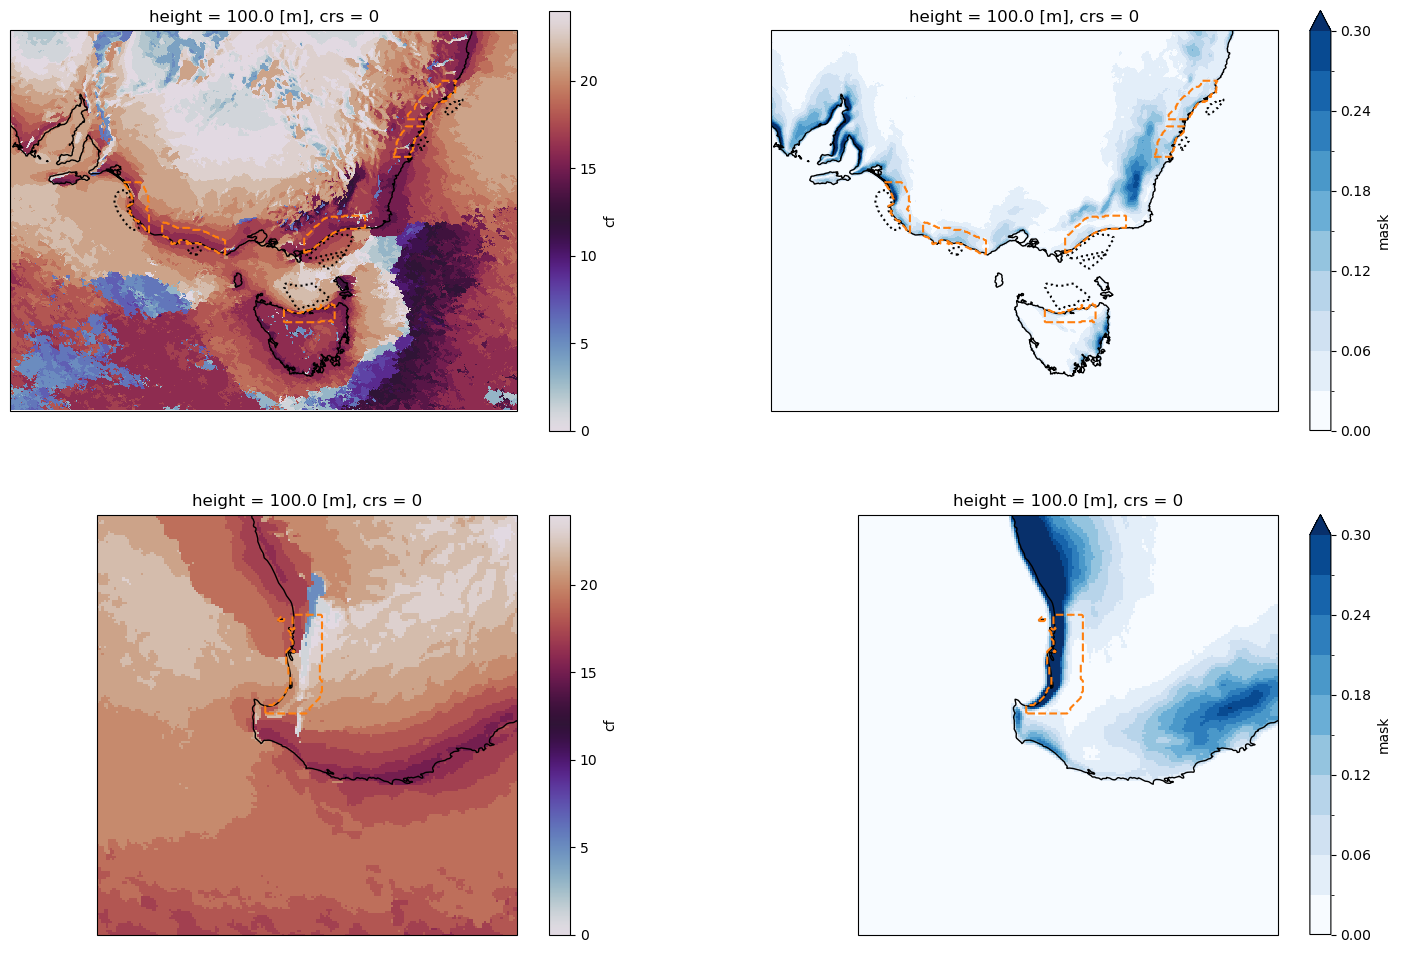

In [9]:
lon_slice = slice(135,155)
lat_slice = slice(-45,-30)

plt.figure(figsize=[18,12])
ax=plt.subplot(2,2,1,projection=ccrs.PlateCarree())
xx,yy=np.meshgrid(ds_mean_djf.lon,ds_mean_djf.lat)
((ds_mean_djf.argmax("hour") + 10) % 24).plot(cmap="twilight",vmin=0,vmax=24)
xr.plot.contour(
    ((raster<6)).sel(lat=lat_slice,lon=lon_slice), levels=1,colors=["k"],linestyles=":")
for shape in [gipps_shape,illawara_shape,newcastle_shape,tas_shape,southern_shape,sa_shape]:
    xr.plot.contour(shape.sel(lat=lat_slice,lon=lon_slice),levels=1,colors=["tab:orange"],linestyles="--")
plt.xlim([lon_slice.start,lon_slice.stop])
plt.ylim([lat_slice.start,lat_slice.stop])
ax.coastlines()


ax=plt.subplot(2,2,2,projection=ccrs.PlateCarree())
sb_aest_mean_djf.plot(cmap='Blues',levels=np.linspace(0,0.3,11))
xr.plot.contour(
    ((raster<6)).sel(lat=lat_slice,lon=lon_slice), levels=1,colors=["k"],linestyles=":")
for shape in [gipps_shape,illawara_shape,newcastle_shape,tas_shape,southern_shape,sa_shape]:
    xr.plot.contour(shape.sel(lat=lat_slice,lon=lon_slice),levels=1,colors=["tab:orange"],linestyles="--")
ax.coastlines()
plt.xlim([lon_slice.start,lon_slice.stop])
plt.ylim([lat_slice.start,lat_slice.stop])




lon_slice = slice(112,120)
lat_slice = slice(-38,-30)

ax=plt.subplot(2,2,3,projection=ccrs.PlateCarree())
xx,yy=np.meshgrid(ds_mean_djf.lon,ds_mean_djf.lat)
((ds_mean_djf.argmax("hour") + 8) % 24).plot(cmap="twilight",vmin=0,vmax=24)
xr.plot.contour(
    ((raster<6)).sel(lat=lat_slice,lon=lon_slice), levels=1,colors=["k"],linestyles=":")
for shape in [bunbury_shape]:
    xr.plot.contour(shape.sel(lat=lat_slice,lon=lon_slice),levels=1,colors=["tab:orange"],linestyles="--")
plt.xlim([lon_slice.start,lon_slice.stop])
plt.ylim([lat_slice.start,lat_slice.stop])
ax.coastlines()


ax=plt.subplot(2,2,4,projection=ccrs.PlateCarree())
sb_awst_mean_djf.plot(cmap='Blues',levels=np.linspace(0,0.3,11))
xr.plot.contour(
    ((raster<6)).sel(lat=lat_slice,lon=lon_slice), levels=1,colors=["k"],linestyles=":")
for shape in [bunbury_shape]:
    xr.plot.contour(shape.sel(lat=lat_slice,lon=lon_slice),levels=1,colors=["tab:orange"],linestyles="--")
ax.coastlines()
plt.xlim([lon_slice.start,lon_slice.stop])
plt.ylim([lat_slice.start,lat_slice.stop])

## Define a time series of "sea breeze days" for each coastal region (associated with each REZ), and save as a .csv

In [10]:
lon_slice = slice(112,155)
lat_slice = slice(-45,-30)

df_sb_shape = []
for shape, region in zip(
    [gipps_shape,illawara_shape,newcastle_shape,tas_shape,southern_shape,sa_shape,bunbury_shape],
    ["gipps","illawara","newcastle","tas","southern","sa","bunbury"]):

    if region in ["bunbury"]:
        shape_sb = xr.where(shape.sel(lat=lat_slice,lon=lon_slice)==1,sb_obj_awst,np.nan).max(("lat","lon")).persist()
    else:
        shape_sb = xr.where(shape.sel(lat=lat_slice,lon=lon_slice)==1,sb_obj_aest,np.nan).max(("lat","lon")).persist()
        
    shape_sb_df = shape_sb.to_dataframe(name="sb")
    df_sb_shape.append(shape_sb_df)
    shape_sb_df.drop(columns=["height","crs"]).to_csv("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/sb_days/"+region+".csv")

In [11]:
# (df_sb_shape[0][df_sb_shape[0]["sb"]==1].loc[slice("1979-01-01","2002-12-31")].index.month.value_counts().sort_index() / \
#  df_sb_shape[0].loc[slice("1979-01-01","2002-12-31")].index.month.value_counts().sort_index()).plot(marker="o")

# (df_sb_shape[0][df_sb_shape[0]["sb"]==1].loc[slice("2003-01-01","2024-12-31")].index.month.value_counts().sort_index() / \
#  df_sb_shape[0].loc[slice("2003-01-01","2024-12-31")].index.month.value_counts().sort_index()).plot(marker="o")


# plt.title("Gippsland")
# plt.ylim([0,0.6])




In [12]:
tasmax_mon = xr.open_mfdataset(
    "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/mon/tasmax/latest/tasmax_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_mon_*"
)
tasmax_mon = tasmax_mon.sel(time=slice("1979-01-01","2024-12-31"),lat=raster.lat,lon=raster.lon).persist()

# u_mon = xr.open_mfdataset(
#     "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/mon/ua850/latest/ua850_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_mon_*"
# )
# u_mon = u_mon.sel(time=slice("1979-01-01","2024-12-31"),lat=raster.lat,lon=raster.lon).persist()

# v_mon = xr.open_mfdataset(
#     "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/mon/va850/latest/va850_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_mon_*"
# )
# v_mon = v_mon.sel(time=slice("1979-01-01","2024-12-31"),lat=raster.lat,lon=raster.lon).persist()

# ws = np.sqrt(u_mon.ua850**2 + v_mon.va850**2).persist()

# uprime,vprime = rotate_wind(u_mon.ua850,v_mon.va850,angle_ds.angle_interp)
# uprime=uprime.persist()
# vprime=vprime.persist()

# huss_mon = xr.open_mfdataset(
#     "/g/data/ob53/BARRA2/output/reanalysis/AUST-04/BOM/ERA5/historical/hres/BARRA-C2/v1/mon/huss/latest/huss_AUST-04_ERA5_historical_hres_BOM_BARRA-C2_v1_mon_*"
# )
# huss_mon = huss_mon.sel(time=slice("1979-01-01","2024-12-31"),lat=raster.lat,lon=raster.lon).persist()

In [13]:
regions = ["gipps","illawara","newcastle","tas","southern","sa","bunbury"]
land_sea = []

for shape in [gipps_shape_landsea,illawara_shape_landsea,newcastle_shape_landsea,tas_shape_landsea,southern_shape_landsea,sa_shape_landsea,bunbury_shape_landsea]:

    land = xr.where(
        (shape) & (lsm.sftlf >= 0.5),
        tasmax_mon.tasmax,
        np.nan).mean(("lat","lon")).groupby("time.month").mean().persist()
    
    sea = xr.where(
        (shape) & (lsm.sftlf < 0.5),
        tasmax_mon.tasmax,
        np.nan).mean(("lat","lon")).groupby("time.month").mean().persist()

    land_sea.append(land-sea)

/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 10.06 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/cli

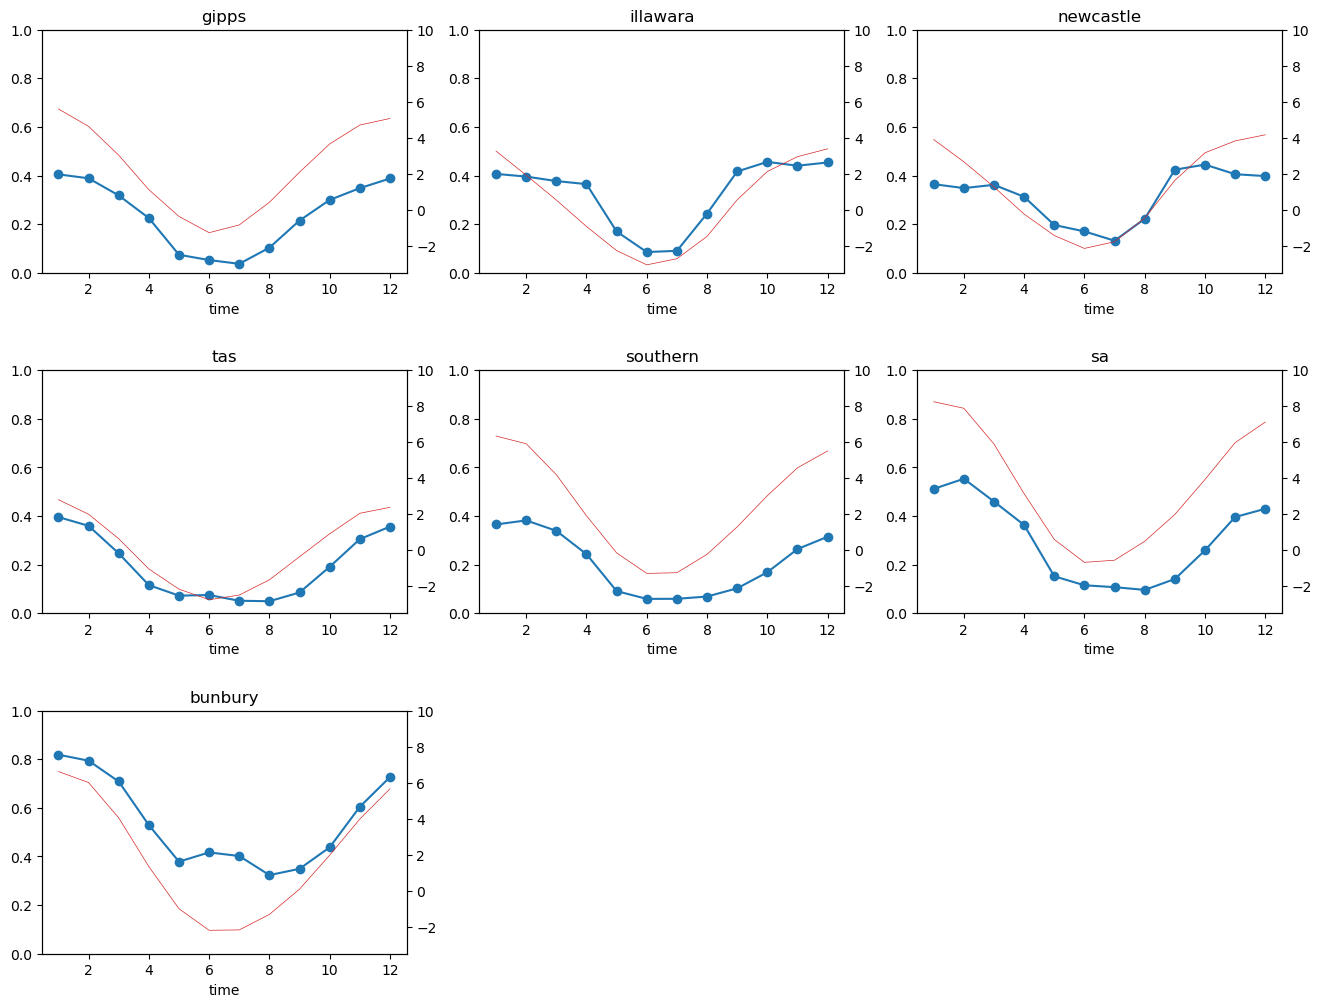

In [19]:
plt.figure(figsize=[16,12])

cnt=1
for i in np.arange(len(regions)):

    plt.subplot(3,3,cnt)
    (df_sb_shape[i][df_sb_shape[i]["sb"]==1].index.month.value_counts().sort_index() / \
     df_sb_shape[i].index.month.value_counts().sort_index()).plot(marker="o")
    plt.ylim([0,1])

    plt.gca().twinx()
    land_sea[i].plot(color="tab:red",lw=0.5)
    plt.ylim([-3.5,10])

    plt.title(regions[i])

    
    cnt=cnt+1

plt.subplots_adjust(hspace=0.4)

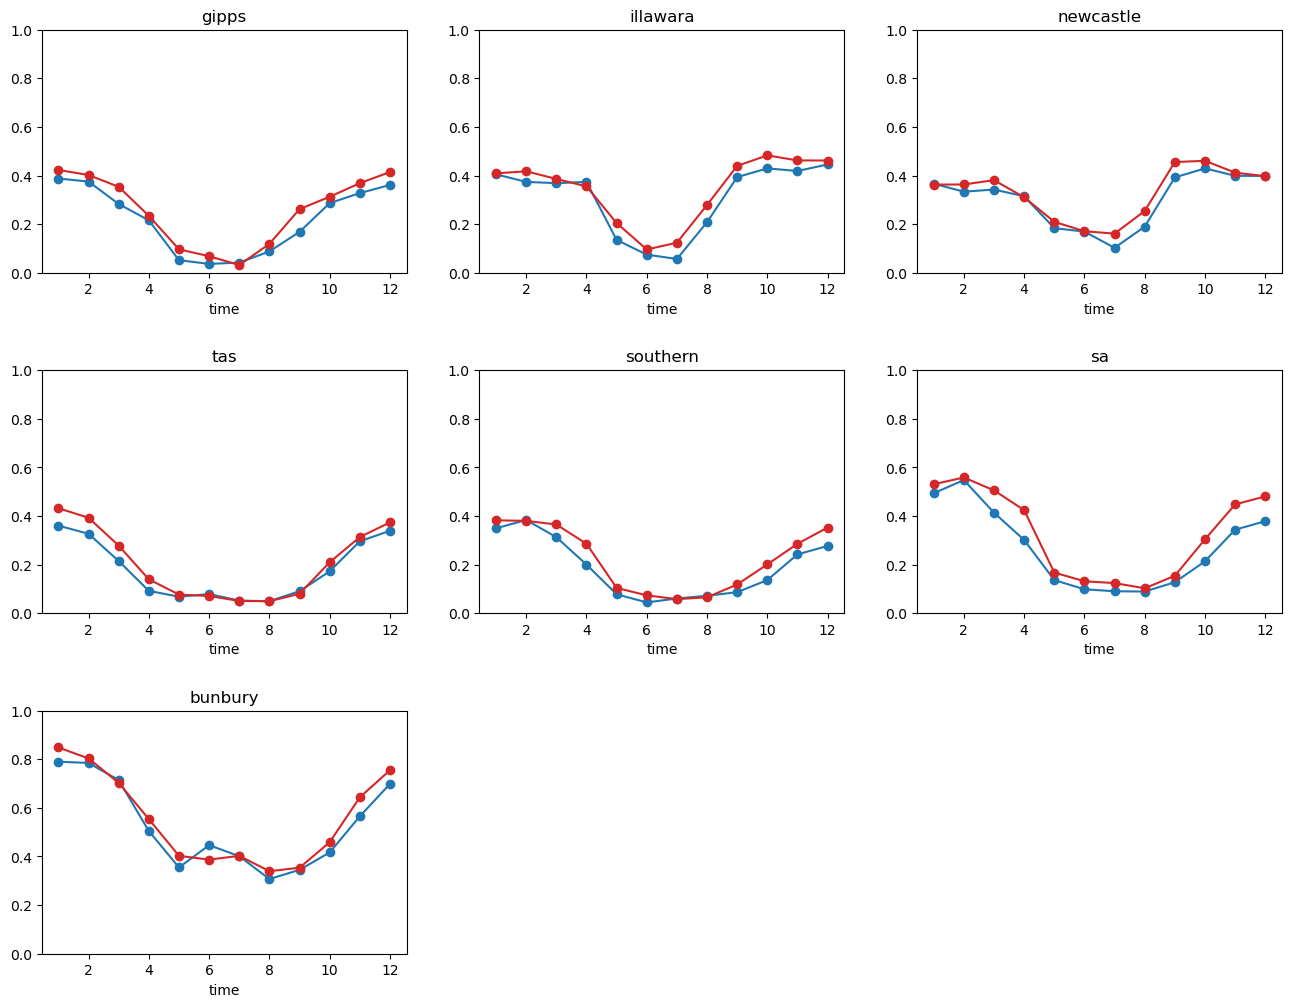

In [28]:
plt.figure(figsize=[16,12])

cnt=1
for i in np.arange(len(regions)):

    
    plt.subplot(3,3,cnt)

    temp = df_sb_shape[i].loc[slice("1979-01-01","2001-12-31")]
    (temp[temp["sb"]==1].index.month.value_counts().sort_index() / \
     temp.index.month.value_counts().sort_index()).plot(marker="o",color="tab:blue")

    temp = df_sb_shape[i].loc[slice("2002-01-01","2024-12-31")]
    (temp[temp["sb"]==1].index.month.value_counts().sort_index() / \
         temp.index.month.value_counts().sort_index()).plot(marker="o",color="tab:red")
    
    plt.ylim([0,1])
    plt.title(regions[i])
    cnt=cnt+1

plt.subplots_adjust(hspace=0.4)

## Plot seasonal cycle in SB days for some other regions compared with previous papers

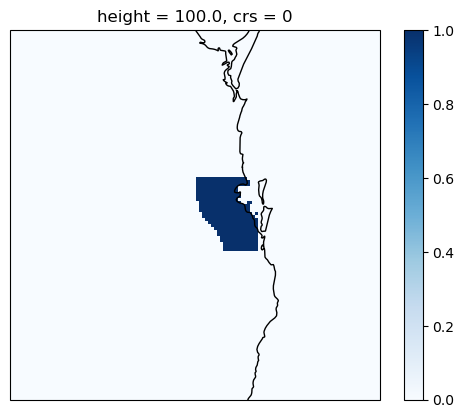

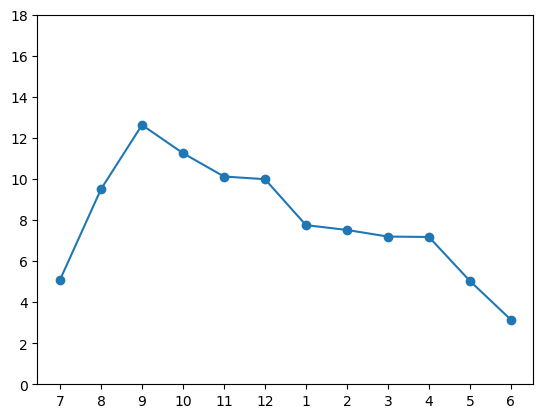

In [14]:
bris_lon_slice = slice(151,153.375)
bris_lat_slice = slice(-28,-27)
#bris_lon_slice = slice(151,154)

bris_sb_obj = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",engine="zarr",chunks={}).mask.sel(lat=bris_lat_slice,lon=bris_lon_slice).persist()
bris_shape = define_coastal_region(bris_lat_slice,bris_lon_slice,angle_ds) * (lsm.sftlf>=0.5)

shape = bris_shape
shape_sb = xr.where(shape.sel(lat=bris_lat_slice,lon=bris_lon_slice)==1,bris_sb_obj,np.nan).max(("lat","lon")).persist()
shape_sb_df = shape_sb.to_dataframe(name="sb")

ax=plt.axes(projection=ccrs.PlateCarree())
bris_shape.plot(cmap="Blues")
plt.ylim([-30,-25])
plt.xlim([150,155])
ax.coastlines()

plt.figure()
plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[7,8,9,10,11,12,1,2,3,4,5,6]].values * 30,marker="o")
plt.ylim([0,18])
plt.xticks(np.arange(12),np.array([7,8,9,10,11,12,1,2,3,4,5,6]).astype(str));

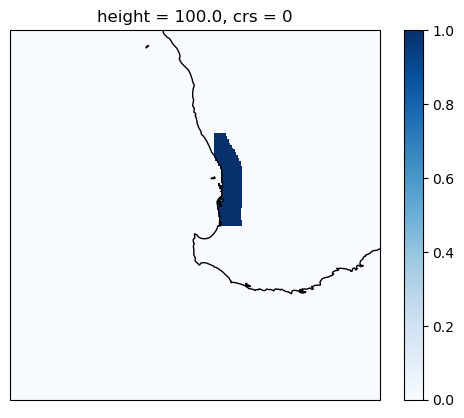

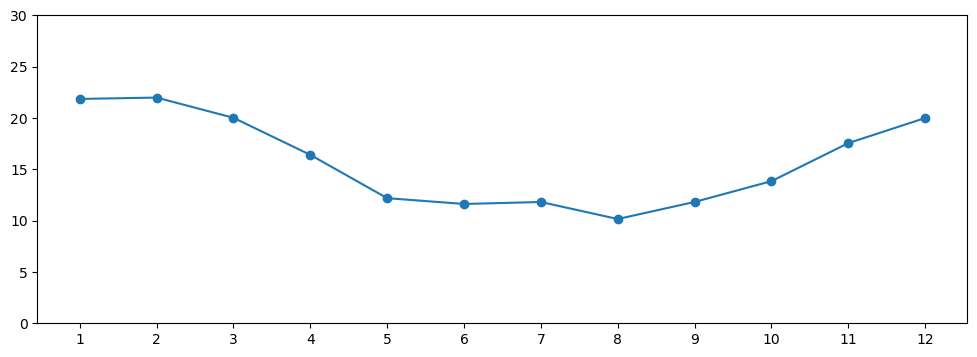

In [19]:
perth_lon_slice = slice(115.5,116.3)
perth_lat_slice = slice(-33.3,-30.8)

perth_sb_obj = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",
                               engine="zarr",chunks={}).mask.sel(lat=perth_lat_slice,lon=perth_lon_slice).persist()
perth_shape = define_coastal_region(perth_lat_slice,perth_lon_slice,angle_ds) * (lsm.sftlf>=0.5)

shape = perth_shape
shape_sb = xr.where(shape.sel(lat=perth_lat_slice,lon=perth_lon_slice)==1,perth_sb_obj,np.nan).max(("lat","lon")).persist()
shape_sb_df = shape_sb.to_dataframe(name="sb")

ax=plt.axes(projection=ccrs.PlateCarree())
perth_shape.plot(cmap="Blues")
plt.ylim([-38,-28])
plt.xlim([110,120])
ax.coastlines()

plt.figure(figsize=[12,4])
plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[1,2,3,4,5,6,7,8,9,10,11,12]].values * 30,marker="o")
plt.ylim([0,30])
plt.xticks(np.arange(12),np.array([1,2,3,4,5,6,7,8,9,10,11,12]).astype(str));

(0.0, 70.0)

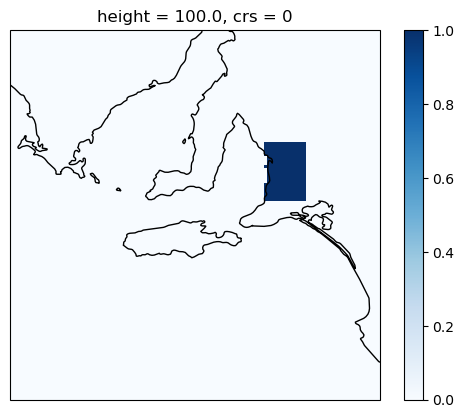

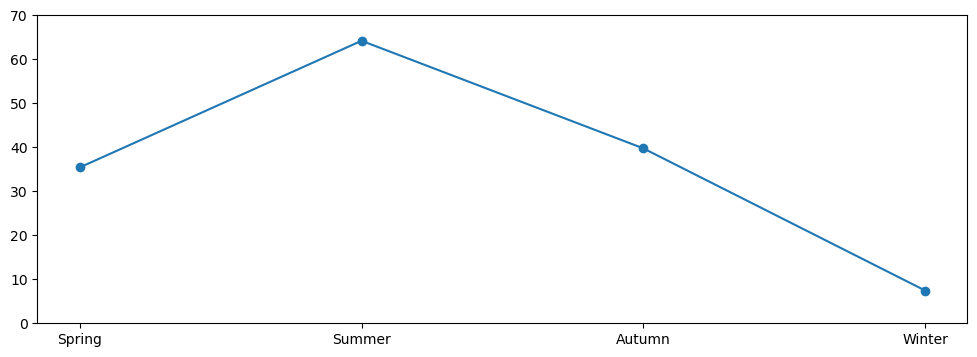

In [42]:
adelaide_lon_slice = slice(138.45,139)
adelaide_lat_slice = slice(-35.3,-34.5)

adelaide_sb_obj = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",
                               engine="zarr",chunks={}).mask.sel(lat=adelaide_lat_slice,lon=adelaide_lon_slice).persist()
adelaide_shape = define_coastal_region(adelaide_lat_slice,adelaide_lon_slice,angle_ds) * (lsm.sftlf>=0.5)

shape = adelaide_shape
shape_sb = xr.where(shape.sel(lat=adelaide_lat_slice,lon=adelaide_lon_slice)==1,adelaide_sb_obj,np.nan).max(("lat","lon")).persist()
shape_sb_df = shape_sb.to_dataframe(name="sb")

ax=plt.axes(projection=ccrs.PlateCarree())
adelaide_shape.plot(cmap="Blues")
plt.ylim([-38,-33])
plt.xlim([135,140])
ax.coastlines()

plt.figure(figsize=[12,4])
#plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
#     shape_sb_df.index.month.value_counts().sort_index()).loc[[1,2,3,4,5,6,7,8,9,10,11,12]].values * 100,marker="o")

monthly_percent = (shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[1,2,3,4,5,6,7,8,9,10,11,12]].values * 100

seasonal_percent = [
    (monthly_percent[8] + monthly_percent[9] + monthly_percent[10])/3,
    (monthly_percent[0] + monthly_percent[1] + monthly_percent[11])/3,
    (monthly_percent[2] + monthly_percent[3] + monthly_percent[4])/3,
    (monthly_percent[5] + monthly_percent[6] + monthly_percent[7])/3]

plt.plot([0,1,2,3],seasonal_percent,marker="o")
plt.xticks(np.arange(4),np.array(["Spring","Summer","Autumn","Winter"]).astype(str));

plt.ylim([0,70])


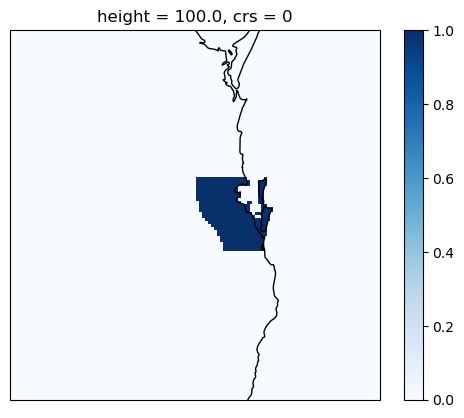

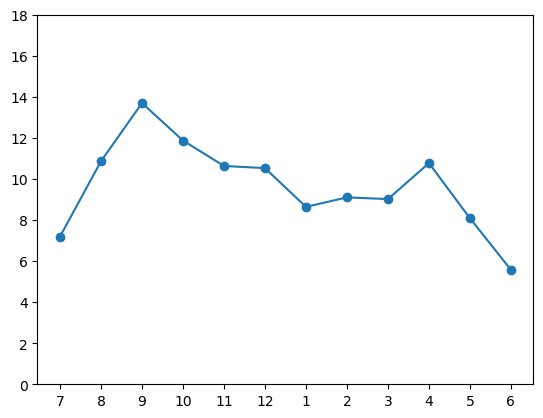

In [196]:
bris_lon_slice = slice(151,154)
bris_lat_slice = slice(-28,-27)
#bris_lon_slice = slice(151,154)

bris_sb_obj = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",engine="zarr",chunks={}).mask.sel(lat=bris_lat_slice,lon=bris_lon_slice).persist()
bris_shape = define_coastal_region(bris_lat_slice,bris_lon_slice,angle_ds) * (lsm.sftlf>=0.5)

shape = bris_shape
shape_sb = xr.where(shape.sel(lat=bris_lat_slice,lon=bris_lon_slice)==1,bris_sb_obj,np.nan).max(("lat","lon")).persist()
shape_sb_df = shape_sb.to_dataframe(name="sb")

ax=plt.axes(projection=ccrs.PlateCarree())
bris_shape.plot(cmap="Blues")
plt.ylim([-30,-25])
plt.xlim([150,155])
ax.coastlines()

plt.figure()
plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[7,8,9,10,11,12,1,2,3,4,5,6]].values * 30,marker="o")
plt.ylim([0,18])
plt.xticks(np.arange(12),np.array([7,8,9,10,11,12,1,2,3,4,5,6]).astype(str));

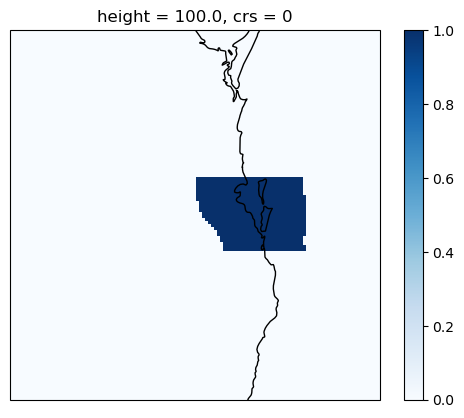

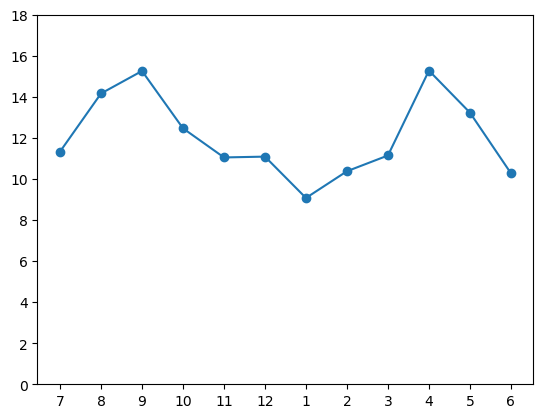

In [197]:
bris_lon_slice = slice(151,154)
bris_lat_slice = slice(-28,-27)
#bris_lon_slice = slice(151,154)

bris_sb_obj = xr.open_dataset("/g/data/ng72/ab4502/sea_breeze_detection/barra_c_smooth_s2/filters/daily_filtered_standard_F_aest_19790101_20250101.zarr",engine="zarr",chunks={}).mask.sel(lat=bris_lat_slice,lon=bris_lon_slice).persist()
bris_shape = define_coastal_region(bris_lat_slice,bris_lon_slice,angle_ds)

shape = bris_shape
shape_sb = xr.where(shape.sel(lat=bris_lat_slice,lon=bris_lon_slice)==1,bris_sb_obj,np.nan).max(("lat","lon")).persist()
shape_sb_df = shape_sb.to_dataframe(name="sb")

ax=plt.axes(projection=ccrs.PlateCarree())
bris_shape.plot(cmap="Blues")
plt.ylim([-30,-25])
plt.xlim([150,155])
ax.coastlines()

plt.figure()
plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[7,8,9,10,11,12,1,2,3,4,5,6]].values * 30,marker="o")
plt.ylim([0,18])
plt.xticks(np.arange(12),np.array([7,8,9,10,11,12,1,2,3,4,5,6]).astype(str));

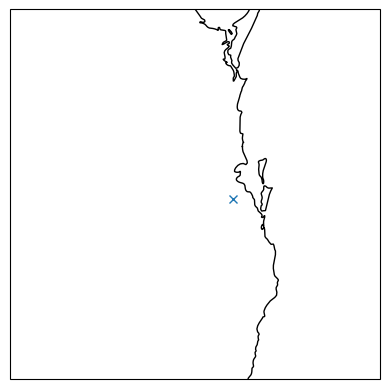

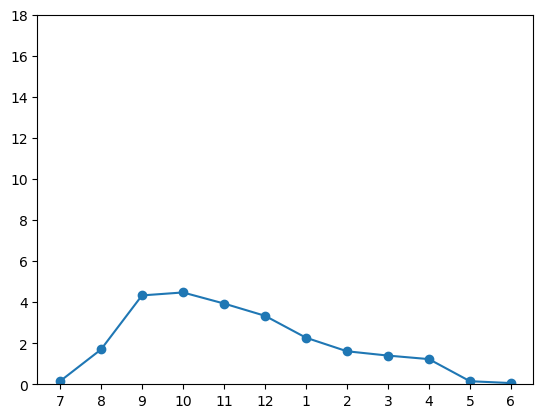

In [206]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.plot(153.012831,-27.569283,marker="x")
plt.ylim([-30,-25])
plt.xlim([150,155])
ax.coastlines()

shape_sb_df = bris_sb_obj.sel(lat=-27.569283,lon=153.012831, method="nearest").to_dataframe(name="sb")
plt.figure()
plt.plot((shape_sb_df[shape_sb_df["sb"]==1].index.month.value_counts().sort_index() / \
     shape_sb_df.index.month.value_counts().sort_index()).loc[[7,8,9,10,11,12,1,2,3,4,5,6]].values * 30,marker="o")
plt.ylim([0,18])
plt.xticks(np.arange(12),np.array([7,8,9,10,11,12,1,2,3,4,5,6]).astype(str));